# Sentiment Analysis on Amazon Product Reviews

This notebook takes a closer look at the content of reviews of [Amazon food products](https://www.kaggle.com/snap/amazon-fine-food-reviews). Using the transformers library, a text classification model is imported and used to predict the sentiment of each review. Lastly, these predictions are compared to the star ratings that the customers gave the products themselves.

#### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

#### Load Data

In [2]:
reviews = pd.read_csv('Reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      568454 non-null  int64  
 1   ProductId               568454 non-null  object 
 2   UserId                  568454 non-null  object 
 3   ProfileName             568438 non-null  object 
 4   HelpfulnessNumerator    568454 non-null  int64  
 5   HelpfulnessDenominator  568454 non-null  int64  
 6   Score                   568454 non-null  int64  
 7   Time                    568454 non-null  int64  
 8   Summary                 568427 non-null  object 
 9   Text                    568454 non-null  object 
 10  Sentiment               568454 non-null  object 
 11  Confidence              568454 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 52.0+ MB


In [3]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Confidence
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,POSITIVE,0.998385
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE,0.999525
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,POSITIVE,0.999765
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,POSITIVE,0.999153
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,POSITIVE,0.998708


#### Data Visualization

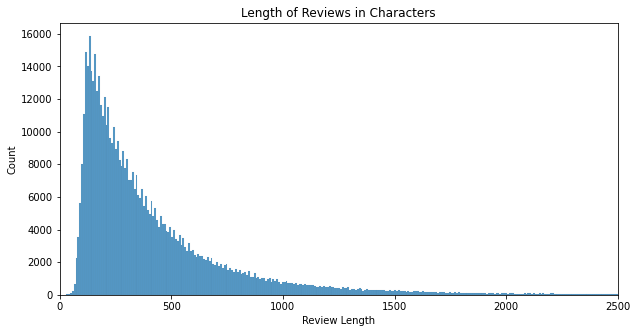

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(data=reviews['Text'].apply(lambda x: len(x)).rename('Review Length'))
plt.xlim(0, 2500)
plt.title('Length of Reviews in Characters')
plt.savefig('plots/lenReviews.png', bbox_inches='tight')
plt.show()

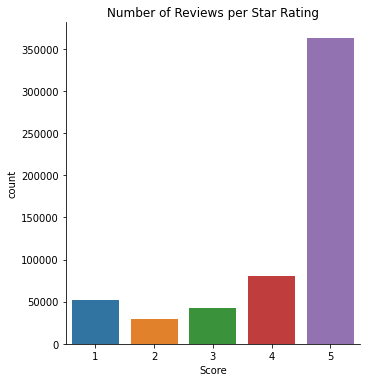

In [5]:
sns.catplot(x='Score', data=reviews, kind='count')
plt.title('Number of Reviews per Star Rating')
plt.savefig('plots/numReviews.png', bbox_inches='tight')
plt.show()

#### Sentiment Analysis

In [ ]:
reviews['Sentiment'] = pd.Series(dtype='str')
reviews['Confidence'] = pd.Series(dtype='float64')

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

for i in np.arange(len(reviews)):
    if (i%1000==0): print(round(i/len(reviews)*100, 2), '%')
    review = reviews.loc[i,'Text']
    tokens = tokenizer(reviews.loc[i,'Text'], padding=True, truncation=True, return_tensors="tf")
    outputs = model(tokens)
    predictions = tf.math.softmax(outputs.logits, axis=-1)
    label = 'NEGATIVE' if predictions[0][0] > predictions[0][1] else 'POSITIVE'
    score = max(predictions.numpy()[0])
    reviews.loc[i,'Sentiment'] = label
    reviews.loc[i,'Confidence'] = score
    
reviews.to_csv('Reviews.csv', index=False)

Word cloud for positive reviews

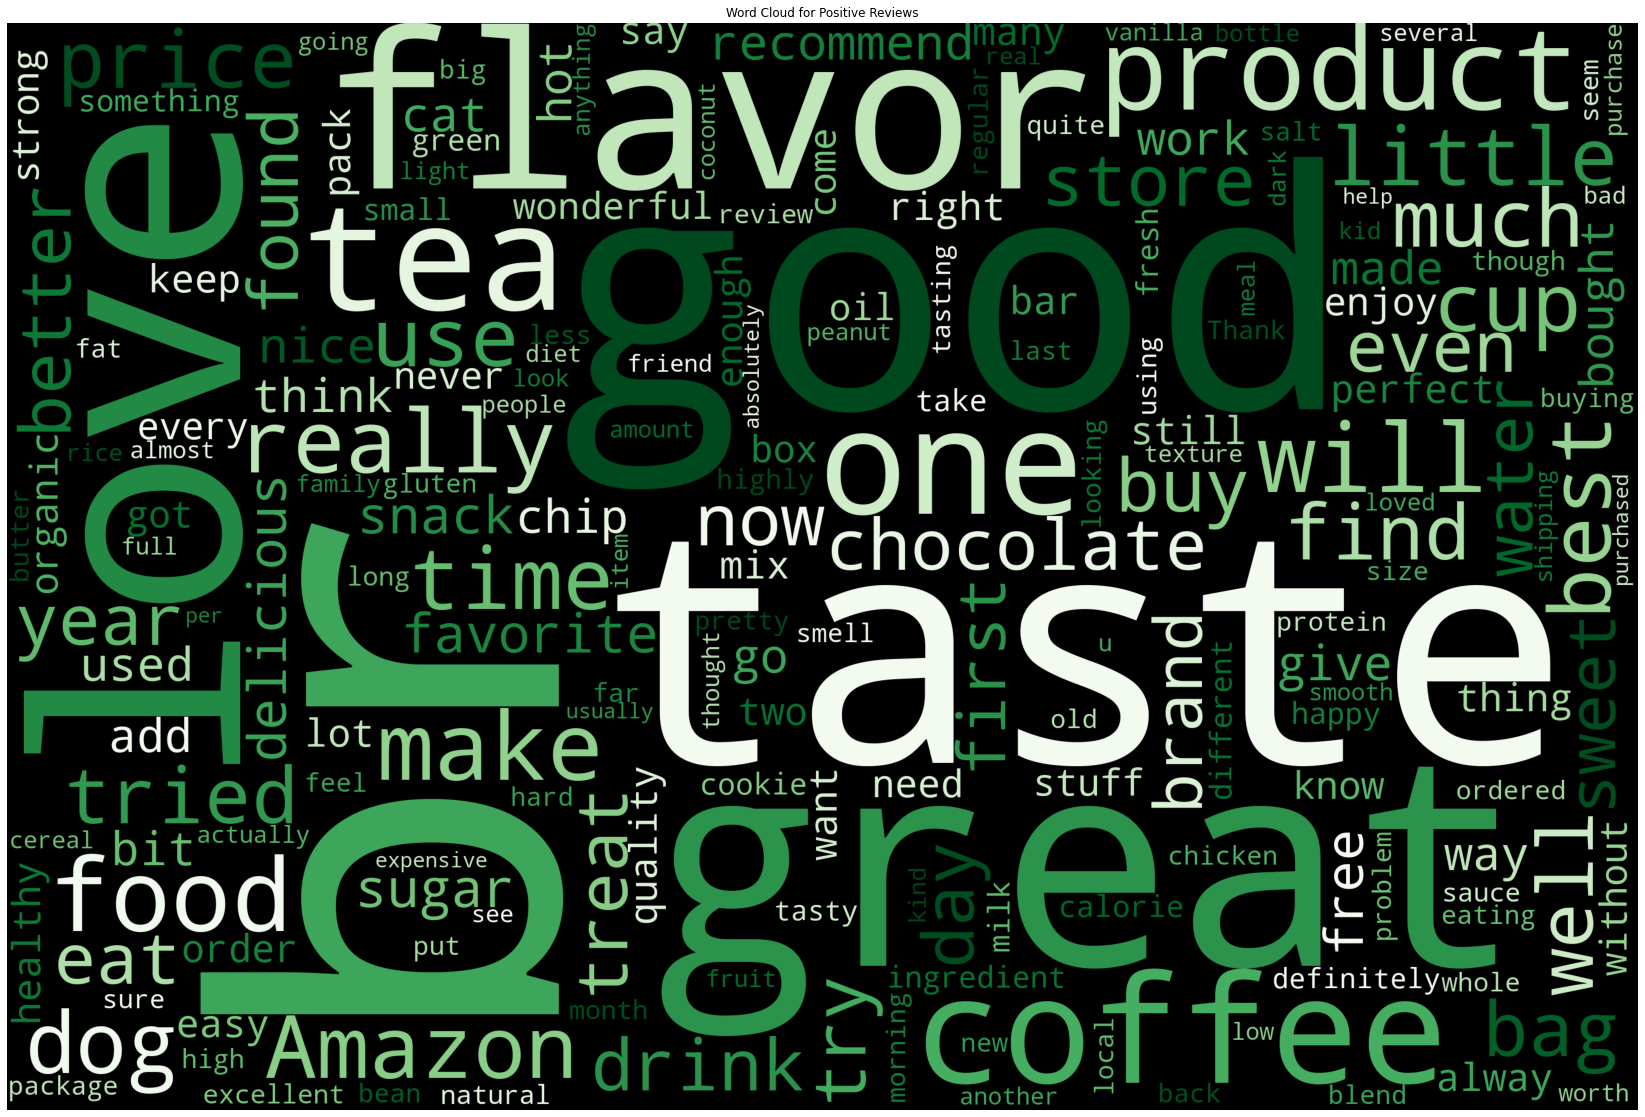

In [6]:
posText = ' '.join(np.random.choice(reviews[reviews['Sentiment']=='POSITIVE']['Text'], size=10000))
posWordCloud = WordCloud(width=3000, height=2000, colormap='Greens',
                         collocations=False, stopwords = STOPWORDS).generate(posText)
posWordCloud.to_file("plots/posWordCloud.png")
plt.figure(figsize=(30,20))
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.imshow(posWordCloud)

Word cloud for negative reviews

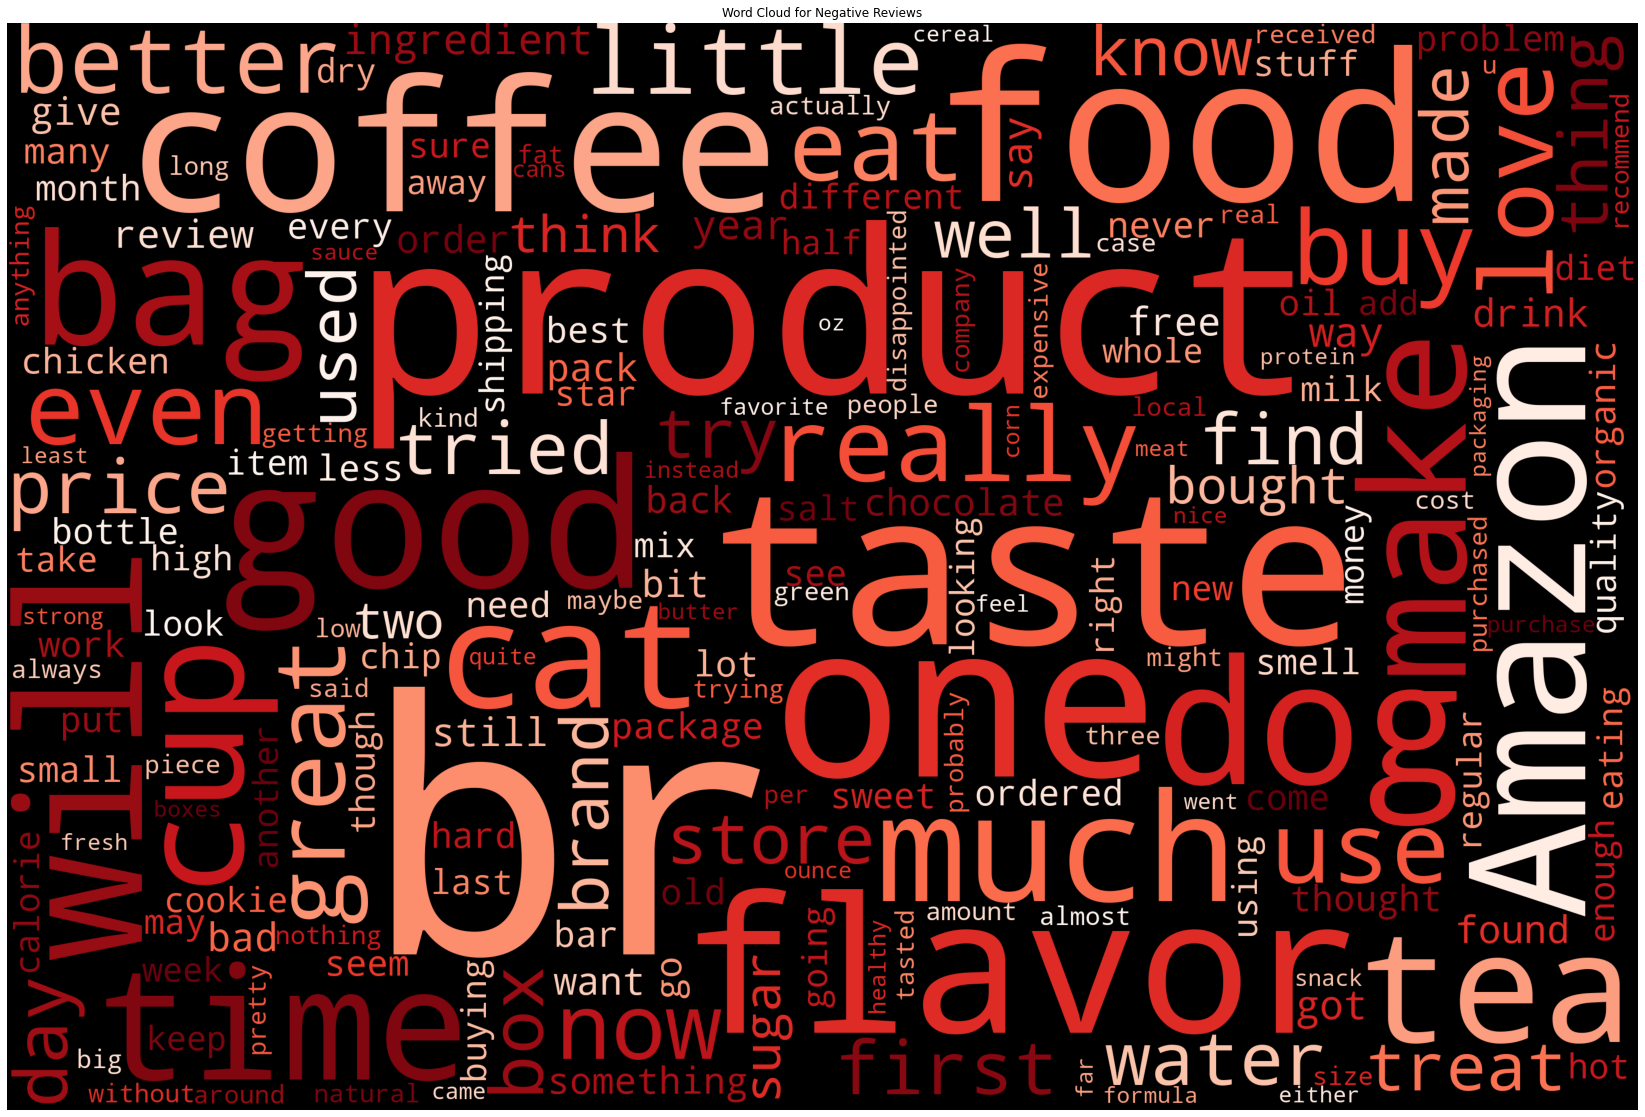

In [7]:
negText = ' '.join(np.random.choice(reviews[reviews['Sentiment']=='NEGATIVE']['Text'], size=10000))
negWordCloud = WordCloud(width=3000, height=2000, colormap='Reds',
                         collocations=False, stopwords = STOPWORDS).generate(negText)
negWordCloud.to_file("plots/negWordCloud.png")
plt.figure(figsize=(30,20))
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.imshow(negWordCloud)

#### Calculate Proportions of Sentiments per Score

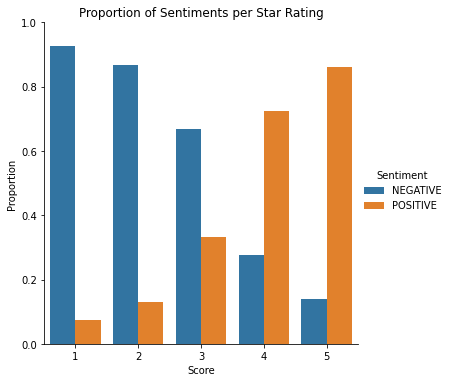

In [8]:
sentiment_per_score = (reviews
                       .groupby('Score')['Sentiment']
                       .value_counts(normalize=True)
                       .rename('Proportion')
                       .reset_index())

sns.catplot(x='Score',y='Proportion', hue='Sentiment', data=sentiment_per_score, kind='bar')
plt.title('Proportion of Sentiments per Star Rating')
plt.ylim(0,1)
plt.savefig('plots/sentimentProportions.png', bbox_inches='tight')
plt.show()